plotting timeseries for test runs

In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [2]:
from scipy.stats import ttest_ind

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# aggregation indices
os.chdir('/w2-data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA

In [5]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N

    y_avg = np.convolve(y, avg_mask, 'same')
    return y_avg    

In [6]:
def read_data(data_dir,t_start=0,t_end=721):
    os.chdir(data_dir)
    print(data_dir)
    file_name = glob('*nc')
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
    data_3d = xr.open_dataset('cm1out_sub3d.nc')
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    data_q3d = xr.open_dataset('cm1out_q3d.nc')
    
    # 3d data
    th3d = data_3d.th[t_start:t_end,:30,:,:]
    qc_3d = data_q3d.qc[t_start:t_end,:,:,:]
    qi_3d = data_q3d.qi[t_start:t_end,:,:,:]
    
    # zonal mean data
    th = data_zon.th[t_start:t_end,:,:,:]
    qv = data_zon.qv[t_start:t_end,:,:,:]
    u = data_zon.uinterp[t_start:t_end,:,:,:]
    v = data_zon.vinterp[t_start:t_end,:,:,:]
    w = data_zon.winterp[t_start:t_end,:,:,:]
    prs = data_zon.prs[t_start:t_end,:,:,:]
    # 2d data
    prate = data_2d.prate[t_start:t_end,:,:]
    pwat = data_2d.pwat[t_start:t_end,:,:]
    cwp = data_2d.cwp[t_start:t_end,:,:]
    cape = data_2d.cape[t_start:t_end,:,:]
    cin = data_2d.cin[t_start:t_end,:,:]
    
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))

    x_dim = data_2d.lon
    y_dim = data_2d.lat
    div = np.gradient(v,y_dim*1000,axis=2) # du/dx+dv/dy 
    vor = -np.gradient(u,y_dim*1000,axis=2) # -du/dy+dv/dx
    #relative humidty calculation, Buck (1996)
    es_liq = 0.61121*np.exp((18.678-T/234.5)*(T/(257.14+T)))*10 #[hpa]
    es_ice = 0.61115*np.exp((23.036-T/333.7)*(T/(279.82+T)))*10

    qs_liq = 0.622*es_liq/(prs/100-es_liq)
    qs_ice = 0.622*es_ice/(prs/100-es_ice)

    rh = qv/qs_liq
    rh_ice = qv/qs_ice

    rh = rh.values.flatten()
    rh_ice = rh_ice.values.flatten()
    T_test = T.values.flatten()

    rh[T_test<0] = rh_ice[T_test<0]
    rh = rh.reshape((T.shape[0],T.shape[1],T.shape[2],T.shape[3]))
    rh = xr.DataArray(rh,coords=[T.time,T.lev,T.lat,T.lon],dims=['time','lev','lat','lon'])
    
    return (th,T,qv,qc_3d,qi_3d,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro,th3d)

In [7]:
exp_outname = ['CTRL','U10','U10_narrow']

In [8]:
# get weather or weather2 
#server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
server = '/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne'
os.chdir(server)

exp_name = ['CM1_LD2km_RAD4K_autoconversion_x1000',
            'CM1_LD2km_RAD4K_autogradx1000_bowen0.2']
#            'CM1_LD2km_RAD4K_OPENMPshear_UNI_216x216_U15H2km',
#            'CM1_LD2km_RAD4K_OPENMPshear_UNI_216x216_U10H2km',
#            'CM1_LD2km_RAD4K_OPENMPshear_UNI_216x216_U5H2km']
print(exp_name)
print('Number of Exp: ', len(exp_name))

['CM1_LD2km_RAD4K_autoconversion_x1000', 'CM1_LD2km_RAD4K_autogradx1000_bowen0.2']
Number of Exp:  2


In [9]:
(th1,T1,qv1,qc1_3d,qi1_3d,rh1,prate1,pwat1,cwp1,u1,v1,w1,div1,vor1,cape1,cin1,prs1,ro1,th1_3d) = read_data(server+'/'+exp_name[0],t_start=0,t_end=721)
(th2,T2,qv2,qc2_3d,qi2_3d,rh2,prate2,pwat2,cwp2,u2,v2,w2,div2,vor2,cape2,cin2,prs2,ro2,th2_3d) = read_data(server+'/'+exp_name[1])
#(th3,T3,qv3,qc3_3d,qi3_3d,rh3,prate3,pwat3,cwp3,u3,v3,w3,div3,vor3,cape3,cin3,prs3,ro3,th3_3d) = read_data(server+'/'+exp_name[2])
#(th4,T4,qv4,qc4_3d,qi4_3d,rh4,prate4,pwat4,cwp4,u4,v4,w4,div4,vor4,cape4,cin4,prs4,ro4,th4_3d) = read_data(server+'/'+exp_name[3])
#(th5,T5,qv5,qc5,qi5,rh5,prate5,pwat5,cwp5,u5,v5,w5,div5,vor5,cape5,cin5,prs5,ro5,th5_3d) = read_data(server+'/'+exp_name[4])
#(th6,T6,qv6,qc6,qi6,rh6,prate6,pwat6,cwp6,u6,v6,w6,div6,vor6,cape6,cin6,prs6,ro6,th6_3d) = read_data(server+'/'+exp_name[5])
#(th7,T7,qv7,qc7,qi7,rh7,prate7,pwat7,cwp7,u7,v7,w7,div7,vor7,cape7,cin7,prs7,ro7,th7_3d) = read_data(server+'/'+exp_name[6])

# (th5,T5,qv5,qc5,qi5,prate5,pwat5,cwp5,u5,v5,w5,div5,vor5,cape5,cin5) = read_data(server+'/'+exp_name[4])

/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_LD2km_RAD4K_autoconversion_x1000
/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_LD2km_RAD4K_autogradx1000_bowen0.2


In [10]:
x_dim = pwat1.lon
y_dim = pwat1.lat
z_dim = T1.lev
t_dim = np.arange(len(T1.time))/3

In [11]:
y_dim2 = pwat2.lat

In [12]:
exp_label = ['auto1000','auto1000_grad','U10']
time_day = np.linspace(0,10,721)

TypeError: Dimensions of C (240, 721) are incompatible with X (721) and/or Y (216); see help(pcolor)

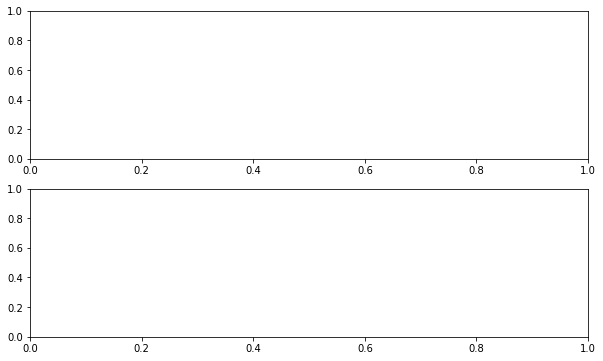

In [17]:
# hovmuller diagram for PWAT and P_y cross
fig,ax = plt.subplots(len(exp_name[:]),1,figsize=(10,3*len(exp_name[:])))

for n,(pwat,prate) in enumerate(zip([pwat1,pwat2],[prate1,prate2])):
    cf = ax[n].pcolor(time_day,y_dim2,pwat.mean('lon').T,cmap='Spectral',vmin=55,vmax=65)
    cbaxes = inset_axes(ax[n], width="2%",height="70%",loc='lower left',
               bbox_to_anchor=(1.02,0.15, 1, 1),bbox_transform=ax[0].transAxes,
               borderpad=0) 
    cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical')
    cbar.set_label('PW [mm]')

    ax[n].contour(time_day,y_dim2,prate.mean('lon').T,levels=[20],colors=['k',]
                 ,linewidths=1)   
    ax[n].set_title(exp_name[n+1],fontsize=14)
    ax[n].set_ylabel('y_dir [km]',fontsize=13)

plt.tight_layout()
#fig.savefig('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/fig_analysis/hovmuller_CMTfree.png',
#           dpi=200,bbox_inches='tight',transparent=False)

TypeError: 'AxesSubplot' object does not support indexing

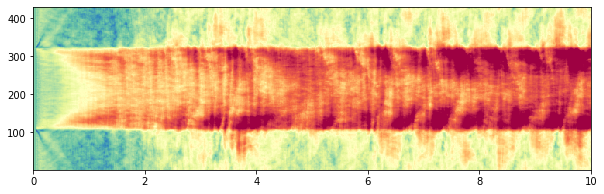

In [64]:
fig,ax = plt.subplots(1,1,figsize=(10,3))

for n,(pwat,prate) in enumerate(zip([pwat4],[prate4])):
    cf = ax.pcolor(time_day,y_dim,pwat.mean('lon').T,cmap='Spectral',vmin=55,vmax=65)
    cbaxes = inset_axes(ax, width="2%",height="70%",loc='lower left',
               bbox_to_anchor=(1.02,0.15, 1, 1),bbox_transform=ax[0].transAxes,
               borderpad=0) 
    cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical')
    cbar.set_label('PW [mm]')

    ax.contour(time_day,y_dim2,prate.mean('lon').T,levels=[20],colors=['k',]
                 ,linewidths=1)   
    ax.set_title(exp_name[n+1],fontsize=14)
    ax.set_ylabel('y_dir [km]',fontsize=13)

Text(0.5, 0, 'Time [hr]')

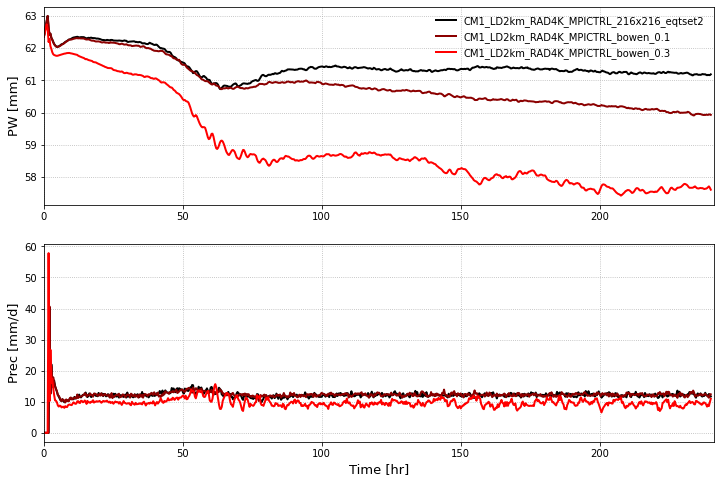

In [58]:
# time
color_label=['k','darkred','r','g']

fig,ax = plt.subplots(2,1,figsize=(12,8))
for n,(pwat,prate) in enumerate(zip([pwat1,pwat2,pwat3]
                                    ,[prate1,prate2,prate3])):

    ax[0].plot(t_dim[:],pwat.mean(('lon','lat'))[:],color=color_label[n],linewidth=2)
    ax[1].plot(t_dim[:],prate.mean(('lon','lat'))[:],color=color_label[n],linewidth=2)

ax[0].set_ylabel('PW [mm]',fontsize=13)
ax[0].set_xlim([0,241])#;ax[0].set_ylim([58,64])
ax[1].set_ylabel('Prec [mm/d]',fontsize=13)
ax[1].set_xlim([0,241]);#ax[1].set_ylim([5,15])
    
ax[0].legend(exp_name,frameon=False)
ax[0].grid(linestyle=':')
ax[1].grid(linestyle=':')
ax[1].set_xlabel('Time [hr]',fontsize=13)
#plt.rcParams(labelsize=13)
#ax[0].set_xlim([150,250])
#ax[1].set_xlim([150,250])
#fig.savefig('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/fig_analysis/domain_PW_Prec_timeseries.pdf',
#           dpi=200,bbox_inches='tight',transparent=False)

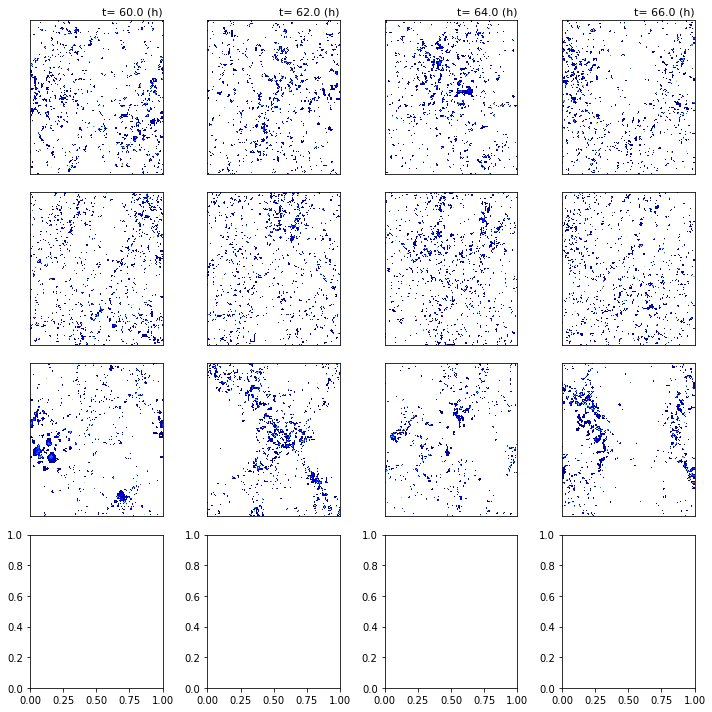

In [65]:
fig,ax = plt.subplots(4,4,figsize=(10,10))

t=180

cf = ax[0,0].pcolor(prate1[t,:,:]/24,vmin=1,cmap='jet');ax[0,0].set_xticks([]);ax[0,0].set_yticks([]);cf.set_clim(1,60)
cf = ax[0,1].pcolor(prate1[t+6,:,:]/24,vmin=1,cmap='jet');ax[0,1].set_xticks([]);ax[0,1].set_yticks([]);cf.set_clim(1,60)
cf = ax[0,2].pcolor(prate1[t+12,:,:]/24,vmin=1,cmap='jet');ax[0,2].set_xticks([]);ax[0,2].set_yticks([]);cf.set_clim(1,60)
cf = ax[0,3].pcolor(prate1[t+18,:,:]/24,vmin=1,cmap='jet');ax[0,3].set_xticks([]);ax[0,3].set_yticks([]);cf.set_clim(1,60)

cf = ax[1,0].pcolor(prate2[t,:,:]/24,vmin=1,cmap='jet');ax[1,0].set_xticks([]);ax[1,0].set_yticks([]);cf.set_clim(1,60)
cf = ax[1,1].pcolor(prate2[t+6,:,:]/24,vmin=1,cmap='jet');ax[1,1].set_xticks([]);ax[1,1].set_yticks([]);cf.set_clim(1,60)
cf = ax[1,2].pcolor(prate2[t+12,:,:]/24,vmin=1,cmap='jet');ax[1,2].set_xticks([]);ax[1,2].set_yticks([]);cf.set_clim(1,60)
cf = ax[1,3].pcolor(prate2[t+18,:,:]/24,vmin=1,cmap='jet');ax[1,3].set_xticks([]);ax[1,3].set_yticks([]);cf.set_clim(1,60)

cf = ax[2,0].pcolor(prate3[t,:,:]/24,vmin=1,cmap='jet');ax[2,0].set_xticks([]);ax[2,0].set_yticks([]);cf.set_clim(1,60)
cf = ax[2,1].pcolor(prate3[t+6,:,:]/24,vmin=1,cmap='jet');ax[2,1].set_xticks([]);ax[2,1].set_yticks([]);cf.set_clim(1,60)
cf = ax[2,2].pcolor(prate3[t+12,:,:]/24,vmin=1,cmap='jet');ax[2,2].set_xticks([]);ax[2,2].set_yticks([]);cf.set_clim(1,60)
cf = ax[2,3].pcolor(prate3[t+18,:,:]/24,vmin=1,cmap='jet');ax[2,3].set_xticks([]);ax[2,3].set_yticks([]);cf.set_clim(1,60)

# cf = ax[3,0].pcolor(prate4[t,:,:]/24,vmin=1,cmap='jet');ax[3,0].set_xticks([]);ax[3,0].set_yticks([]);cf.set_clim(1,60)
# cf = ax[3,1].pcolor(prate4[t+6,:,:]/24,vmin=1,cmap='jet');ax[3,1].set_xticks([]);ax[3,1].set_yticks([]);cf.set_clim(1,60)
# cf = ax[3,2].pcolor(prate4[t+12,:,:]/24,vmin=1,cmap='jet');ax[3,2].set_xticks([]);ax[3,2].set_yticks([]);cf.set_clim(1,60)
# cf = ax[3,3].pcolor(prate4[t+18,:,:]/24,vmin=1,cmap='jet');ax[3,3].set_xticks([]);ax[3,3].set_yticks([]);cf.set_clim(1,60)

ax[0,0].set_title('t= '+str(t/3)+' (h)',loc='right',fontsize=11)
ax[0,1].set_title('t= '+str((t+6)/3)+' (h)',loc='right',fontsize=11)
ax[0,2].set_title('t= '+str((t+12)/3)+' (h)',loc='right',fontsize=11)
ax[0,3].set_title('t= '+str((t+18)/3)+' (h)',loc='right',fontsize=11)

cf.cmap.set_under('w')

# shear belt area

plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(6,8))
for i,(u,prate,w) in enumerate(zip([u1,u2,u3],[prate1,prate2,prate3],[w1,w2,w3])):
    cf = ax[i].contourf(time_day,y_dim,u[:,1,:,0].T,levels=[2,4,6,8,10,12,14],cmap='terrain')
    #ax[i].contour(prate[:,:,:].mean(dim='lon').T,levels=np.linspace(30,80,11),colors=['r'])
    cbar = plt.colorbar(cf,ax=ax[i])
    cbar.set_label('[m/s]',fontsize=12)
    tmp = np.copy(w[:,14,:,0].values)
    tmp[w[:,14,:,0]<0] = np.nan
    tmp[w[:,14,:,0]>0.1] = 1
    ax[i].contour(time_day,y_dim,tmp.T,colors=['r'])
    ax[i].set_xlim([0,2])
    ax[i].set_title(exp_label[i])
    ax[i].set_ylabel('Y [km]',fontsize=13)
    ax[i].grid(linestyle=':',linewidth=1)
    ax[i].set_xlabel('Day',fontsize=13)
plt.tight_layout()
fig.savefig('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/fig_analysis/Uwind_w0.1_CMT_free.pdf',
           dpi=200,bbox_inches='tight',transparent=False)

In [ ]:
plt.hist(cwp[:,:,:].mean(dim='lon'))

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(6,8))
for i,(pwat,cwp,w) in enumerate(zip([pwat1,pwat2,pwat3],[cwp1,cwp2,cwp3],[w1,w2,w3])):
    cf = ax[i].contourf(pwat[:,:,:].mean(dim='lon').T,cmap='BrBG',levels=np.linspace(56,64,9))
    ax[i].contour(cwp[:,:,:].mean(dim='lon').T,colors=['r'],levels=np.linspace(0.1,0.2,10))
    cbar = plt.colorbar(cf,ax=ax[i])
    ax[i].set_xlim([0,400])
    ax[i].set_title(exp_label[i])
    ax[i].set_ylabel('Y [km]',fontsize=13)
    ax[i].grid(linestyle=':',linewidth=1)
plt.tight_layout()

In [ ]:
# plotting zonal mean
# y cross-section
marker_label=['s','o']
color_label=['k','darkred','r','darkgreen']

fig,ax = plt.subplots(2,1,figsize=(9,7))

for n,data in enumerate([pwat1,pwat2,pwat3,pwat4]):
    ax[0].plot(x_dim,np.nanmean(data[-360:,:,:],axis=(0,1)),color=color_label[n]
              ,label=exp_label[n],linewidth=2)
    #ax[0].plot(x_dim,np.ones(len(x_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])
    
    ax[1].plot(y_dim,np.nanmean(data[-360:,:,:],axis=(0,2)),color=color_label[n]
              ,label=exp_label[n],linewidth=2)
#    ax[1].plot(y_dim,np.ones(len(y_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])

ax[0].legend(frameon=False,fontsize=8,ncol=2);
ax[0].set_xlabel('x direction [km]',fontsize=14);ax[0].set_ylim([57,63])
ax[0].set_ylabel('CWV [mm]',fontsize=14)
ax[1].set_xlabel('y direction [km]',fontsize=14);ax[1].set_ylim([57,63])
ax[1].set_ylabel('CWV [mm]',fontsize=14)
ax[0].set_xlim([0,432])
ax[1].set_xlim([0,432])
plt.tight_layout(h_pad=1)
ax[0].grid(linestyle=':')
ax[1].grid(linestyle=':')
ax[1].legend(frameon=False,fontsize=8,ncol=2);
ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#fig.savefig(fig_out+'PWAT_crosssection.png',dpi=200,bbox_inches='tight')

In [ ]:
# y cross-section 
marker_label=['s','o']

fig,ax = plt.subplots(2,1,figsize=(9,7))

for n,data in enumerate([prate1,prate2,prate3,prate4]):
    ax[0].plot(x_dim,running_mean(np.nanmean(data[-360:,:,:],axis=(0,1)),window_N=3),color=color_label[n]
              ,label=exp_label[n],linewidth=2)
    
    ax[1].plot(y_dim,running_mean(np.nanmean(data[-360:,:,:],axis=(0,2)),window_N=3),color=color_label[n]
              ,label=exp_label[n],linewidth=2)
    ax[0].plot(x_dim,np.ones(len(x_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])
    ax[1].plot(y_dim,np.ones(len(y_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])

ax[0].legend(frameon=False,fontsize=8,ncol=2);
ax[1].legend(frameon=False,fontsize=8,ncol=2);

ax[0].set_xlabel('x direction [km]',fontsize=14);ax[0].set_xlim([0,432])
ax[0].set_ylim([6,22])
ax[0].set_ylabel('Precip [mm/d]',fontsize=14)
ax[1].set_xlabel('y direction [km]',fontsize=14);ax[1].set_xlim([0,432])
ax[1].set_ylabel('Precip [mm/d]',fontsize=14)
ax[1].set_ylim([6,22])
ax[0].grid(linestyle=':')
ax[1].grid(linestyle=':')

plt.tight_layout(h_pad=0.5)
ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#fig.savefig(fig_out+'PREC_crosssection.png',dpi=200,bbox_inches='tight')

In [ ]:
exp_outname

In [ ]:
prate1_zmn = np.nanmean(prate1[-360:,65:151,:],axis=(1,2))
prate2_zmn = np.nanmean(prate2[-360:,65:151,:],axis=(1,2))
prate3_zmn = np.nanmean(prate3[-360:,87:129,:],axis=(1,2))
prate4_zmn = np.nanmean(prate4[-360:,43:173,:],axis=(1,2))

print(ttest_ind(prate2_zmn,prate3_zmn))

In [ ]:
# precip domain-averaged, shear region and non-shear region
fig,ax = plt.subplots(1,1,figsize=(5,6))
ax.plot(1,np.nanmean(prate1[-360:,65:151,:],axis=(0,1,2)),'ok',markersize=8,label=exp_outname[0])
pr1_ns = np.concatenate((prate1[:,-43:,:],prate1[:,:43,:]))
ax.plot(1,np.nanmean(pr1_ns[-360:,:,:],axis=(0,1,2)),'xk',markersize=8)

ax.plot(2,np.nanmean(prate2[-360:,65:151,:],axis=(0,1,2)),'or',markersize=8,label=exp_outname[1])
pr2_ns = np.concatenate((prate2[:,-43:,:],prate2[:,:43,:]))
ax.plot(2,np.nanmean(pr2_ns[-360:,:,:],axis=(0,1,2)),'xr',markersize=8)

ax.plot(3,np.nanmean(prate3[-360:,87:129,:],axis=(0,1,2)),'og',markersize=8,label=exp_outname[2])
pr3_ns = np.concatenate((prate3[:,-65:,:],prate3[:,:65,:]))
ax.plot(3,np.nanmean(pr3_ns[-360:,:,:],axis=(0,1,2)),'xg',markersize=8)

ax.plot(4,np.nanmean(prate4[-360:,43:173,:],axis=(0,1,2)),'ob',markersize=8,label=exp_outname[3])
pr4_ns = np.concatenate((prate4[:,-21:,:],prate4[:,:21,:]))
ax.plot(4,np.nanmean(pr4_ns[-360:,:,:],axis=(0,1,2)),'xb',markersize=8)

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['CTRL','U10','U10_narrow','U10_wide'],fontsize=12)
ax.set_ylabel('P [mm/hr]',fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

### Meridional Moisture Convergence 

In [22]:
qv1.lev[:45]

<xarray.DataArray 'lev' (lev: 45)>
array([ 0.025   ,  0.086842,  0.172368,  0.281579,  0.414474,  0.571053,
        0.751316,  0.955263,  1.182895,  1.434211,  1.709211,  2.007895,
        2.330263,  2.676316,  3.046053,  3.439474,  3.856579,  4.297369,
        4.761843,  5.25    ,  5.75    ,  6.25    ,  6.75    ,  7.25    ,
        7.75    ,  8.25    ,  8.75    ,  9.25    ,  9.75    , 10.250001,
       10.750001, 11.250001, 11.750001, 12.250001, 12.750001, 13.250001,
       13.750001, 14.250001, 14.750001, 15.250001, 15.750001, 16.25    ,
       16.75    , 17.25    , 17.75    ])
Coordinates:
  * lev      (lev) float64 0.025 0.08684 0.1724 0.2816 ... 16.75 17.25 17.75
Attributes:
    axis:     Z

In [17]:
qv1.shape

(721, 65, 216, 1)

In [35]:
merid_qv_conv.shape

(45, 216)

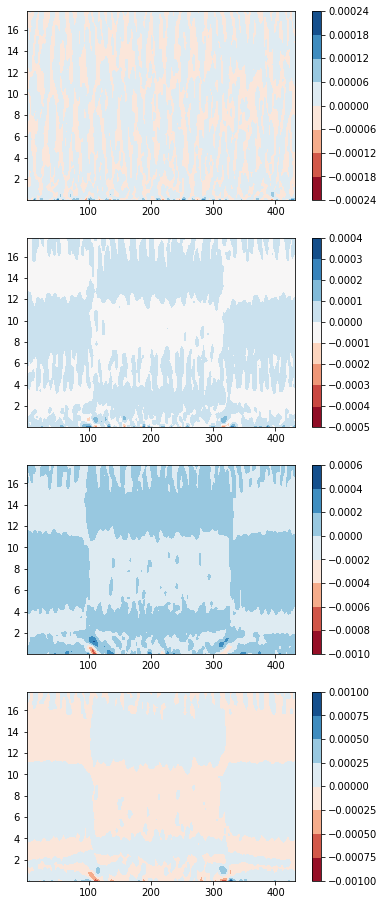

In [42]:
# d(qv)/dy moisture flux convergence

merid_qv_conv = np.zeros((len(y_dim),len(z_dim)))

fig,ax = plt.subplots(4,1,figsize=(6,4*len(exp_label)))
for n, (ro,qv,v) in enumerate(zip([ro1,ro2,ro3,ro4],[qv1,qv2,qv3,qv4],[v1,v2,v3,v4])):
    tmp = np.gradient(ro[-360:,:45,:,0]*qv[-360:,:45,:,0]*v[-360:,:45,:,0],y_dim,axis=2)
    merid_qv_conv = np.nanmean(tmp,axis=0)
    cf = ax[n].contourf(y_dim,z_dim[:45],merid_qv_conv,cmap='RdBu')
    plt.colorbar(cf,ax=ax[n])

In [ ]:
%%time
# streamfunction, anelastic + boussinesq==> grad(ro*V) = 0
strmf1 = np.zeros((len(t_dim),len(z_dim),len(y_dim)))
strmf2 = np.zeros((len(t_dim),len(z_dim),len(y_dim)))
strmf3 = np.zeros((len(t_dim),len(z_dim),len(y_dim)))
strmf4 = np.zeros((len(t_dim),len(z_dim),len(y_dim)))

for t in range(len(t_dim)):
    for n in range(len(z_dim)):
        strmf1[t,n,:] = np.trapz(ro1[t,:n,:,0]*v1[t,:n,:,0],z_dim[:n]*1000,axis=0) 
        strmf2[t,n,:] = np.trapz(ro2[t,:n,:,0]*v2[t,:n,:,0],z_dim[:n]*1000,axis=0)
        strmf3[t,n,:] = np.trapz(ro3[t,:n,:,0]*v3[t,:n,:,0],z_dim[:n]*1000,axis=0)
        strmf4[t,n,:] = np.trapz(ro4[t,:n,:,0]*v4[t,:n,:,0],z_dim[:n]*1000,axis=0)

In [ ]:
%%time
fig,ax = plt.subplots(2,2,figsize=(10,10))
nrow = [0,0,1,1]
ncol = [0,1,0,1]
clevs = np.linspace(-1000,1000,21)

for n,(strmf,rh) in enumerate(zip([strmf1,strmf2,strmf3,strmf4]
                         ,[rh1,rh2,rh3,rh4])):
    ax[nrow[n],ncol[n]].contour(y_dim,z_dim,strmf[-360:,:,:].mean(axis=0),levels=clevs,linewidths=1,colors='k')
    ax[nrow[n],ncol[n]].contour(y_dim,z_dim,strmf[-360:,:,:].mean(axis=0),levels=['0'],linewidths=2,colors=['w'])
    cf = ax[nrow[n],ncol[n]].pcolor(y_dim,z_dim,100*rh[-360:,:,:,0].mean(axis=0),vmin=40,vmax=100,cmap='BrBG')
    #cbar = plt.colorbar(cf,ax=ax[nrow[n],ncol[n]])
    #cbar.set_label('RH [%]',fontsize=12)
    ax[nrow[n],ncol[n]].set_ylim([0,18])

    ax[nrow[n],ncol[n]].set_ylabel('height [km]',fontsize=13)
    ax[nrow[n],ncol[n]].grid(linestyle=':')
    ax[nrow[n],ncol[n]].set_title(exp_label[n],fontsize=14,loc='right')
    if nrow[n] != 1:
        ax[nrow[n],ncol[n]].set_xticklabels([])
    if nrow[n] == 1:
        ax[nrow[n],ncol[n]].set_xlabel('y direction [km]',fontsize=13)
    
    if n == len(exp_label)-1:
        cbaxes = fig.add_axes([1.01, 0.2, 0.02, 0.6]) 
        cb = plt.colorbar(cf, cax = cbaxes)  
        cb.set_label('Relative humidity [%]',fontsize=13)
    
plt.tight_layout()

In [ ]:
SCAI_time = np.empty((len(exp_outname),2,len(t_dim)))
COP_time = np.empty((len(exp_outname),2,len(t_dim)))

In [ ]:
for n in range(len(exp_outname)):
    SCAI_time[n,:,:] = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/SCAI_com_shear_'+exp_outname[n]+'.npy')
    COP_time[n,:,:] = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/COP_com_shear_'+exp_outname[n]+'.npy')

In [ ]:
shear_int = [0,1,2,3]
shear_depth = [0,1,2,3]

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):

    ax[0].plot(s_int,COP_time[n,0,-360:].mean(),marker='o',markersize=8,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP
    ax[0].plot(s_int,COP_time[n,1,-360:].mean(),marker='x',markersize=8,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP

ax[1].plot(0,np.nanmean(prate1[-360:,65:151,:],axis=(0,1,2)),'o',markersize=8,color=color_label[0]
          ,markerfacecolor='None',markeredgewidth=2)
pr1_ns = np.concatenate((prate1[:,-43:,:],prate1[:,:43,:]))
ax[1].plot(0,np.nanmean(pr1_ns[-360:,:,:],axis=(0,1,2)),'xk',markersize=8,color=color_label[0],markeredgewidth=2)

ax[1].plot(1,np.nanmean(prate2[-360:,65:151,:],axis=(0,1,2)),'o',markersize=8,color=color_label[1]
          ,markerfacecolor='None',markeredgewidth=2)
pr2_ns = np.concatenate((prate2[:,-43:,:],prate2[:,:43,:]))
ax[1].plot(1,np.nanmean(pr2_ns[-360:,:,:],axis=(0,1,2)),'xr',markersize=8,color=color_label[1],markeredgewidth=2)

ax[1].plot(2,np.nanmean(prate3[-360:,87:129,:],axis=(0,1,2)),'o',markersize=8,color=color_label[2]
          ,markerfacecolor='None',markeredgewidth=2)
pr3_ns = np.concatenate((prate3[:,-65:,:],prate3[:,:65,:]))
ax[1].plot(2,np.nanmean(pr3_ns[-360:,:,:],axis=(0,1,2)),'xg',markersize=8,color=color_label[2],markeredgewidth=2)

ax[1].plot(3,np.nanmean(prate4[-360:,43:173,:],axis=(0,1,2)),'o',markersize=8,color=color_label[3]
          ,markerfacecolor='None',markeredgewidth=2)
pr4_ns = np.concatenate((prate4[:,-21:,:],prate4[:,:21,:]))
ax[1].plot(3,np.nanmean(pr4_ns[-360:,:,:],axis=(0,1,2)),'xb',markersize=8,color=color_label[3],markeredgewidth=2)

#ax[0].legend(exp_label,fontsize=10)
ax[0].set_ylabel('COP',fontsize=15)
ax[1].set_ylabel('Precip [mm/d]',fontsize=15)
ax[0].set_xticks([0,1,2,3]);ax[0].set_xticklabels(['CTRL','U10','Narrow','Wide'],fontsize=13);
ax[1].set_xticks([0,1,2,3]);ax[1].set_xticklabels(['CTRL','U10','Narrow','Wide'],fontsize=13);

In [ ]:
shear_int = [0,10,10,10]
shear_depth = [0,10,10,10]

fig,ax = plt.subplots(1,2,figsize=(10,5))

for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):

    ax[0].plot(s_int,COP_time[n,0,-360:].mean(),marker='^',markersize=13,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP
ax[0].legend(exp_label,fontsize=10)

for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):
    ax[0].plot(s_int,COP_time[n,1,-360:].mean(),marker='x',markersize=13,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP

for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):

    ax[1].plot(s_int,COP_time[n,0,-360:].mean()-COP_time[n,1,-360:].mean(),marker='o',markersize=12,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP
ax[1].legend(exp_label,fontsize=10)
    
ax[0].set_xlabel('shear intensity [s$^{-1}$]',fontsize=15)
ax[1].set_xlabel('shear intensity [s$^{-1}$]',fontsize=15)
ax[0].set_ylabel('COP',fontsize=18);#plt.ylim([0,10])
ax[1].set_ylabel('$\Delta$COP',fontsize=18);#plt.ylim([0,10])
ax[0].grid(linestyle=":")
ax[1].grid(linestyle=":")
ax[0].tick_params(labelsize=13)
ax[1].tick_params(labelsize=13)
ax[1].set_title('COP difference (S-NS)')
plt.tight_layout()

#fig.savefig(fig_out+'COP_shearintensity.png',dpi=200,bbox_inches='tight')
# for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):

#      plt.plot(s_int,COP_pr_time[n,0,-360:].mean()-COP_pr_time[n,1,-360:].mean(),marker='o',markersize=12,linestyle='None'
#                  ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP_pr

In [ ]:
%%time
fig,ax = plt.subplots(2,3,figsize=(12,8))
nrow = [0,0,0,1,1,1]
ncol = [0,1,2,0,1,2]
clevs = np.linspace(-0.2,0.2,11)

for n,(strmf,rh) in enumerate(zip([ro1*w1,ro1*w2,ro1*w3,ro1*w4]
                         ,[rh1,rh2,rh3,rh4])):
    cf=ax[nrow[n],ncol[n]].contourf(y_dim,z_dim,-9.8*strmf[-360:,:,:,0].mean(axis=0),levels=clevs,linewidths=1,cmap='RdBu')
    #ax[nrow[n],ncol[n]].contour(y_dim,z_dim,9.8*strmf[-360:,:,:,0].mean(axis=0),levels=clevs,linewidths=0.5,color='k')
    #ax[nrow[n],ncol[n]].contour(y_dim,z_dim,strmf[-360:,:,:,0].mean(axis=0),levels=['0'],linewidths=2,colors=['w'])
    #cf = ax[nrow[n],ncol[n]].pcolor(y_dim,z_dim,100*rh[-360:,:,:,0].mean(axis=0),vmin=40,vmax=100,cmap='BrBG')
    #cbar = plt.colorbar(cf,ax=ax[nrow[n],ncol[n]])
    #cbar.set_label('RH [%]',fontsize=12)
    ax[nrow[n],ncol[n]].set_ylim([0,18])

    ax[nrow[n],ncol[n]].set_ylabel('height [km]',fontsize=13)
    ax[nrow[n],ncol[n]].grid(linestyle=':')
    ax[nrow[n],ncol[n]].set_title(exp_label[n],fontsize=14,loc='right')
    if nrow[n] != 1:
        ax[nrow[n],ncol[n]].set_xticklabels([])
    if nrow[n] == 1:
        ax[nrow[n],ncol[n]].set_xlabel('y direction [km]',fontsize=13)
    
    if n == len(exp_label)-1:
        cbaxes = fig.add_axes([1.01, 0.2, 0.02, 0.6]) 
        cb = plt.colorbar(cf, cax = cbaxes)  
        cb.set_label('Omega [Pa/s]',fontsize=13)
    
plt.tight_layout()
#fig.savefig(fig_out+'rh_strm_crosssection.png',dip=200,bbox_inches='tight')

In [ ]:
# lumpsize distribution 
def lumpsize_dist(prec,y_st=65,y_sed=151,y_nst=-43,y_nsed=43):
    
    size_cri = np.linspace(0,400,101)
    lumpsize_dist = np.zeros((2,len(size_cri)-1))

    for t in range(prec.shape[0]):
        pr_s = prec[t,y_st:y_sed,:] # only in the shear region
        pr_ns = np.concatenate((prec[t,y_nst:,:],prec[t,:y_nsed,:]))
        cldmask_s = np.zeros(pr_s.shape)
        cldmask_ns = np.zeros(pr_ns.shape)
        cldmask_s[pr_s> 5] = 1 # cloudmaks, prec>5mm/d, cold cloud
        cldmask_ns[pr_ns> 5] = 1 # cloudmaks, prec>5mm/d, cold cloud
        
        try:
        # shear region
            labeled_array, num_feature = labeled_obj(cldmask_s,1,1)
            for label in np.unique(labeled_array)[1:]:
                tmp = len(np.where(labeled_array == label)[0])
                for i in range(len(size_cri)-1):
                    if (tmp >= size_cri[i]) and (tmp < size_cri[i+1]):
                        lumpsize_dist[0,i] += 1
        # non-shear region                
            labeled_array, num_feature = labeled_obj(cldmask_ns,1,1)
            for label in np.unique(labeled_array)[1:]:
                tmp = len(np.where(labeled_array == label)[0]) # pixel numbers: size
                for i in range(len(size_cri)-1):
                    if (tmp >= size_cri[i]) and (tmp < size_cri[i+1]):
                        lumpsize_dist[1,i] += 1
                         
        except:
            continue
            
    return lumpsize_dist

In [ ]:
%%time
size_cri = np.linspace(0,400,101)
psize_dist = np.zeros((len(exp_outname),2,len(size_cri)-1))
y_st = [65,65,87,43]
y_sed = [151,151,129,173]
y_nst = [-43,-43,-65,-21]
y_nsed = [43,43,65,21]

for n,prate in enumerate([prate1,prate2,prate3,prate4]):
    tmp = prate[-360:,:,:]
    psize_dist[n,:,:] = lumpsize_dist(tmp,y_st[n],y_sed[n],y_nst[n],y_nsed[n])

In [ ]:
nrow = [0,0,1,1]
ncol = [0,1,0,1]
fig,ax = plt.subplots(2,2,figsize=(10,10))

for n in range(len(exp_label)):
    ax[nrow[n],ncol[n]].plot(4*size_cri[:-1], psize_dist[n,0,:]/np.sum(psize_dist[n,0,:]),label='Shear region')
    ax[nrow[n],ncol[n]].plot(4*size_cri[:-1], psize_dist[n,1,:]/np.sum(psize_dist[n,1,:]),label='Non-Shear region')
    if n > 0:
        ref_dist = (psize_dist[0,0,:]/np.sum(psize_dist[0,0,:]) + psize_dist[0,1,:]/np.sum(psize_dist[0,1,:]))/2
        ax[nrow[n],ncol[n]].plot(4*size_cri[:-1], ref_dist ,color='lightgrey')
    ax[nrow[n],ncol[n]].set_yscale('log')
    ax[nrow[n],ncol[n]].legend(frameon=False,fontsize=11)
    ax[nrow[n],ncol[n]].set_xlabel('Size [km$^2$]',fontsize=13)
    ax[nrow[n],ncol[n]].set_ylabel('probability',fontsize=13)
    ax[nrow[n],ncol[n]].text(100,1e-1,exp_label[n],fontsize=13)
    ax[nrow[n],ncol[n]].set_ylim([1e-5,0])
    ax[nrow[n],ncol[n]].grid(linestyle=':')
    
#     if n == 3:
#         ax[nrow[n],ncol[n]].spines['bottom'].set_edegcolor('white')
#         ax[nrow[n],ncol[n]].spines['top'].set_edgecolor('w') 
#         ax[nrow[n],ncol[n]].spines['right'].set_edgecolor('w')
#         ax[nrow[n],ncol[n]].spines['left'].set_edgecolor('w')
        #ax[nrow[n],ncol[n]].set_xticks([])

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

for n in range(len(exp_label)):
    ax.plot(4*size_cri[:-1], psize_dist[n,0,:]/np.sum(psize_dist[n,0,:]),label='Shear region')
ax.set_yscale('log')
ax.set_xlabel('Size [km$^2$]',fontsize=13)
ax.set_ylabel('probability',fontsize=13)
ax.set_ylim([1e-5,0])
ax.legend(['CTRL','U10','Narrow','Wide'])

In [ ]:
Z = np.tile(z_dim*1000,reps=(len(t_dim),len(y_dim),1)).swapaxes(1,2)

# MSE time-series
vint_mse = np.zeros((len(exp_name),len(t_dim),216))
vint_Lqv = np.copy(vint_mse)
vint_CpT = np.copy(vint_mse)

for n,(T,qv) in enumerate(zip([T1,T2,T3],[qv1,qv2,qv3])):
    vint_mse[n,:,:] = np.trapz(1004*(T.squeeze()+273.15)+9.8*Z*1000+2.5e6*qv.squeeze(),z_dim*1000,axis=1).squeeze()
    vint_Lqv[n,:,:] = np.trapz(2.5e6*qv,z_dim*1000,axis=1).squeeze()
    vint_CpT[n,:,:] = np.trapz(1004*(T+273.15),z_dim*1000,axis=1).squeeze()

In [ ]:
fig = plt.figure(figsize=(10,5))

for n in range(len(exp_name)):
    plt.plot(t_dim,vint_mse[n,:,:].mean(axis=1)/1000,color=color_label[n],label=exp_name[n],
            linewidth=1.8)
plt.legend(frameon=False)
    
# quantify the drifting of CMSE
del_mse_1deg = np.trapz(1004*np.ones(len(z_dim)),z_dim*1000,axis=0).squeeze()/1000    
plt.plot(t_dim,vint_mse[0,0,:].mean(axis=0)*np.ones(len(t_dim))/1000)

factor=0.5
plt.fill_between(t_dim,vint_mse[0,0,:].mean(axis=0)/1000+factor*del_mse_1deg*np.ones(len(t_dim))
                 ,vint_mse[0,0,:].mean(axis=0)/1000-factor*del_mse_1deg*np.ones(len(t_dim)),color='lightgrey',alpha=0.4)
    
#plt.ylim([23000,23200])
plt.xlim([0,240])
plt.ylabel('CMSE [KJ/kg*m]')
plt.xlabel('Time [hr]')
plt.grid(linestyle=':')

In [ ]:
# plotting zonal mean
# y cross-section
marker_label=['s','o']

fig,ax = plt.subplots(2,1,figsize=(10,7))

for n,data in enumerate([pwat1,pwat2,pwat3]):
    ax[0].plot(x_dim,np.nanmean(data[-360:,:,:],axis=(0,1)),color=color_label[n]
              ,label=exp_label[n],linewidth=2)
    #ax[0].plot(x_dim,np.ones(len(x_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])
    
    ax[1].plot(y_dim,np.nanmean(data[-360:,:,:],axis=(0,2)),color=color_label[n]
              ,label=exp_label[n],linewidth=2)
#    ax[1].plot(y_dim,np.ones(len(y_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])

ax[0].legend(frameon=False,fontsize=8,ncol=2);
ax[0].set_xlabel('x direction [km]',fontsize=12);ax[0].set_ylim([57,63])
ax[0].set_ylabel('CWV [mm]',fontsize=12)
ax[1].set_xlabel('y direction [km]',fontsize=12);ax[1].set_ylim([57,63])
ax[1].set_ylabel('CWV [mm]',fontsize=12)
ax[0].set_xlim([0,432])
ax[1].set_xlim([0,432])
plt.tight_layout(h_pad=1)
ax[0].grid(linestyle=':')
ax[1].grid(linestyle=':')

In [ ]:
# y cross-section 
marker_label=['s','o']

fig,ax = plt.subplots(2,1,figsize=(10,7))

for n,data in enumerate([prate1,prate2,prate3]):
    ax[0].plot(x_dim,running_mean(np.nanmean(data[-360:,:,:],axis=(0,1)),window_N=3),color=color_label[n]
              ,label=exp_name[n],linewidth=2)
    
    ax[1].plot(y_dim,running_mean(np.nanmean(data[-360:,:,:],axis=(0,2)),window_N=3),color=color_label[n]
              ,label=exp_name[n],linewidth=2)
    ax[0].plot(x_dim,np.ones(len(x_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])
    ax[1].plot(y_dim,np.ones(len(y_dim))*np.nanmean(data[-360:,:,:]),'--',color=color_label[n])

#plt.legend();
ax[0].set_xlabel('x direction [km]',fontsize=14);ax[0].set_xlim([0,432])
ax[0].set_ylim([0,22])
ax[0].set_ylabel('Precip [mm/d]',fontsize=14)
ax[1].set_xlabel('y direction [km]',fontsize=14);ax[1].set_xlim([0,432])
ax[1].set_ylabel('Precip [mm/d]',fontsize=14)
ax[1].set_ylim([0,22])
ax[0].grid(linestyle=':')
ax[1].grid(linestyle=':')

plt.tight_layout(h_pad=0.5)

In [ ]:
# T cross section
fig,ax = plt.subplots(len(exp_label),1,figsize=(8,10))

for n,qv in enumerate([qv2,qv3]):
    cf=ax[n].contourf(y_dim,z_dim,1000*qv[-360:,:,:,0].mean(axis=0)-1000*qv1[-360:,:,:,0].mean(axis=0),levels=20,linewidths=2,cmap='RdBu')
    #ax[n].contour(y_dim,z_dim,T[-360:,:,:,0].mean(axis=0),levels=['40'],linewidths=2,colors=['grey'])
    ax[n].set_ylim([0,18])
    if n == 0:
        cbaxes = inset_axes(ax[n], width="2%",height="70%",loc='lower left',
                   bbox_to_anchor=(1.02,0.15, 1, 1),bbox_transform=ax[0].transAxes,
                   borderpad=0) 
        cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical',shrink=1)

    ax[n].set_ylabel('height [km]',fontsize=13)
    ax[n].grid(linestyle=':')
    ax[n].set_title(exp_name[n+1],fontsize=14)
    
ax[n].set_xlabel('y direction [km]',fontsize=13)
plt.tight_layout()

In [ ]:
plt.plot(y_dim,cwp1[-360:,:,:].mean(axis=(0,2)))
plt.plot(y_dim,cwp2[-360:,:,:].mean(axis=(0,2)))
plt.plot(y_dim,cwp3[-360:,:,:].mean(axis=(0,2)))

In [ ]:
# T cross section
fig,ax = plt.subplots(len(exp_label),1,figsize=(8,10))

for n,qv in enumerate([qc2+qi2,qc3+qi3]):
    cf=ax[n].contourf(y_dim,z_dim,1000*qv[-360:,:,:,0].mean(axis=0)-1000*(qc1+qi1)[-360:,:,:,0].mean(axis=0),levels=20,linewidths=2,cmap='RdBu')
    #ax[n].contour(y_dim,z_dim,T[-360:,:,:,0].mean(axis=0),levels=['40'],linewidths=2,colors=['grey'])
    ax[n].set_ylim([0,18])
    if n == 0:
        cbaxes = inset_axes(ax[n], width="2%",height="70%",loc='lower left',
                   bbox_to_anchor=(1.02,0.15, 1, 1),bbox_transform=ax[0].transAxes,
                   borderpad=0) 
        cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical',shrink=1)

    ax[n].set_ylabel('height [km]',fontsize=13)
    ax[n].grid(linestyle=':')
    ax[n].set_title(exp_name[n+1],fontsize=14)
    
ax[n].set_xlabel('y direction [km]',fontsize=13)
plt.tight_layout()

In [ ]:
# lumpsize distribution 

def lumpsize_dist(prec):
    
    size_cri = np.linspace(0,400,101)
    lumpsize_dist = np.zeros((2,len(size_cri)-1))

    for t in range(prec.shape[0]):
        pr_s = prec[t,65:151,:] # only in the shear region
        pr_ns = np.concatenate((prec[t,-43:,:],prec[t,:43,:]))
        cldmask_s = np.zeros(pr_s.shape)
        cldmask_ns = np.copy(cldmask_s)
        cldmask_s[pr_s> 5] = 1 # cloudmaks, prec>5mm/d, cold cloud
        cldmask_ns[pr_ns> 5] = 1 # cloudmaks, prec>5mm/d, cold cloud
        
        try:
        # shear region
            labeled_array, num_feature = labeled_obj(cldmask_s,1,1)
            for label in np.unique(labeled_array)[1:]:
                tmp = len(np.where(labeled_array == label)[0])
                for i in range(len(size_cri)-1):
                    if (tmp >= size_cri[i]) and (tmp < size_cri[i+1]):
                        lumpsize_dist[0,i] += 1
        # non-shear region                
            labeled_array, num_feature = labeled_obj(cldmask_ns,1,1)
            for label in np.unique(labeled_array)[1:]:
                tmp = len(np.where(labeled_array == label)[0]) # pixel numbers: size
                for i in range(len(size_cri)-1):
                    if (tmp >= size_cri[i]) and (tmp < size_cri[i+1]):
                        lumpsize_dist[1,i] += 1
                         
        except:
            continue
            
    return lumpsize_dist

In [ ]:
%%time
size_cri = np.linspace(0,400,101)
psize_dist = np.zeros((len(exp_label),2,len(size_cri)-1))
for n,prate in enumerate([prate1,prate2,prate3,prate4,prate5]):
    tmp = prate[-360:,:,:]
    psize_dist[n,:,:] = lumpsize_dist(tmp)

In [ ]:
nrow = [0,0,1,1,2,2,3]
ncol = [0,1,0,1,0,1,0]
fig,ax = plt.subplots(3,2,figsize=(10,15))

for n in range(len(exp_label)):
    ax[nrow[n],ncol[n]].plot(4*size_cri[:-1], psize_dist[n,0,:]/np.sum(psize_dist[n,0,:]),label='Shear region')
    ax[nrow[n],ncol[n]].plot(4*size_cri[:-1], psize_dist[n,1,:]/np.sum(psize_dist[n,1,:]),label='Non-Shear region')
    if n > 0:
        ref_dist = (psize_dist[0,1,:]/np.sum(psize_dist[0,1,:]) + psize_dist[0,1,:]/np.sum(psize_dist[0,1,:]))/2
        ax[nrow[n],ncol[n]].plot(4*size_cri[:-1], ref_dist ,color='lightgrey')
    ax[nrow[n],ncol[n]].set_yscale('log')
    ax[nrow[n],ncol[n]].legend(frameon=False,fontsize=11)
    ax[nrow[n],ncol[n]].set_xlabel('Size [km$^2$]',fontsize=13)
    ax[nrow[n],ncol[n]].set_ylabel('probability',fontsize=13)
    ax[nrow[n],ncol[n]].text(100,1e-1,exp_label[n],fontsize=13)
    ax[nrow[n],ncol[n]].set_ylim([1e-5,0])
    ax[nrow[n],ncol[n]].grid(linestyle=':')
    
    if n == 7:
        ax[nrow[n],ncol[n]].spines['bottom'].set_edegcolor('white')
        ax[nrow[n],ncol[n]].spines['top'].set_edgecolor('w') 
        ax[nrow[n],ncol[n]].spines['right'].set_edgecolor('w')
        ax[nrow[n],ncol[n]].spines['left'].set_edgecolor('w')
        #ax[nrow[n],ncol[n]].set_xticks([])
        #ax[nrow[n],ncol[n]].set_yticks([])
        
#fig.savefig(fig_out+'objsize_PDF.png',dpi=200,bbox_inches='tight')

In [ ]:
fig_out = '/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/fig_analysis/'

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

color_label2 = ['k','orange','lime','red','green']

for n in range(len(exp_label)):
    ax.plot(4*size_cri[:-1], psize_dist[n,0,:]/np.sum(psize_dist[n,0,:]),label=exp_label[n],
           color=color_label2[n]) 
    ax.set_yscale('log')
ax.set_xlabel('Size [km$^2$]',fontsize=15)
ax.set_ylabel('probability',fontsize=15)
ax.set_ylim([1e-5,0])
ax.grid(linestyle=':')
ax.legend(frameon=False,fontsize=11)
ax.tick_params(labelsize=12)

fig.savefig(fig_out+'psize_dist_UNIvsOG.png',dpi=200,bbox_inches='tight')

In [ ]:
Iorg_UNI_time = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/Iorg_com_UNI.npy')
SCAI_UNI_time = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/SCAI_com_UNI.npy')
COP_UNI_time = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/COP_com_UNI.npy')

In [ ]:
Iorg_time = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/Iorg_com_shear.npy')
SCAI_time = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/SCAI_com_shear.npy')
COP_time = np.load('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/COP_com_shear.npy')

In [ ]:
COP_time_sub = COP_time[[0,1,3,5],...]

In [ ]:
shear_int = [0,7.5,5,2.5]
shear_depth = [0,2,2,2]

fig,ax = plt.subplots(1,2,figsize=(10,5))

for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):

    ax[0].plot(s_int,COP_time_sub[n,0,-360:].mean(),marker='^',markersize=13,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP

for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):
    ax[0].plot(s_int,COP_UNI_time[n,0,-360:].mean(),marker='x',markersize=13,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP
ax[0].legend(['CTRL','U15','U10','U5','CTRL','U15_UNI','U10_UNI','U5_UNI'],fontsize=10,ncol=2)

for n,(s_int,s_dep) in enumerate(zip(shear_int,shear_depth)):

    ax[1].plot(s_int,COP_time_sub[n,0,-360:].mean()-COP_time[n,1,-360:].mean(),marker='o',markersize=12,linestyle='None'
                 ,color=color_label[n],markerfacecolor='None',markeredgewidth=2) # COP
ax[1].legend(['CTRL','U15','U10','U5'],fontsize=10)
    
ax[0].set_xlabel('shear intensity [s$^{-1}$]',fontsize=15)
ax[1].set_xlabel('shear intensity [s$^{-1}$]',fontsize=15)
ax[0].set_ylabel('COP',fontsize=18);#plt.ylim([0,10])
ax[1].set_ylabel('$\Delta$COP',fontsize=18);#plt.ylim([0,10])
ax[0].grid(linestyle=":")
ax[1].grid(linestyle=":")
ax[0].tick_params(labelsize=13)
ax[1].tick_params(labelsize=13)
ax[1].set_title('COP difference (S-NS)')
plt.tight_layout()

#fig.savefig(fig_out+'COP_shearintensity.png',dpi=200,bbox_inches='tight')

### cloud fraction profile

In [ ]:
def cldfrac_cal(qc_3d,qi_3d,cri=1e-5):
    qci_3dmask = np.zeros(qc_3d.shape)
    z_dim = qc_3d.shape[0]

    for k in range(z_dim):
        qci_mask = np.copy(qc_3d[k,:,:]+qi_3d[k,:,:])
        qci_mask[qci_mask>=cri] = 1
        qci_mask[qci_mask<cri] = 0
        qci_3dmask[k,:,:] = qci_mask

    return qci_3dmask

In [ ]:
%%time
cldfrac_all = np.empty((len(exp_name),721,65))

for n,(qc_3d,qi_3d) in enumerate(zip([qc1_3d,qc2_3d,qc3_3d,qc4_3d],[qi1_3d,qi2_3d,qi3_3d,qi4_3d])):
    
    for t in range(721):
        qci_3dmask = cldfrac_cal(qc_3d[t,...],qi_3d[t,...],cri=1e-5)
        cldfrac_all[n,t,:] = qci_3dmask.mean(axis=(1,2))

In [ ]:
for n in range(len(exp_name)):
    plt.plot(cldfrac_all[n,-360:,:].mean(axis=0),qc1_3d.lev)
plt.ylim([0,18])
plt.xlim([0,0.3])
plt.legend(exp_label)